In [1]:
import pandas as pd
import numpy as np
import pyarrow

from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
train = pd.read_parquet(r"D:\Jupyter\Handwriting\IAM-line\data\train.parquet")
test = pd.read_parquet(r"D:\Jupyter\Handwriting\IAM-line\data\test.parquet")
val = pd.read_parquet(r"D:\Jupyter\Handwriting\IAM-line\data\validation.parquet")

In [3]:
train.head()

,text,image
0,put down a resolution on the subject,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,and he is to be backed by Mr. Will,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,nominating any more Labour life Peers,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,M Ps tomorrow. Mr. Michael Foot has,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,"Griffiths, M P for Manchester Exchange .",{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [4]:
def img(image):
    return Image.open(io.BytesIO(image['bytes']))

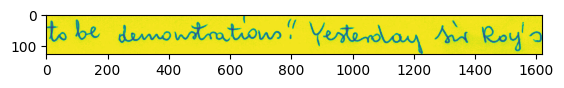

to be demonstrations . " Yesterday Sir Roy's


In [5]:
image = img(train["image"][100])
plt.imshow(image)
plt.show()
print(train["text"][100])

In [12]:
# Function to resize images while maintaining the height
def resize_image(image, target_width, target_height=128):
    return image.resize((target_width, target_height), Image.LANCZOS)

# Function to normalize image
def normalize_image(image):
    image_array = np.array(image) / 255.0
    return Image.fromarray((image_array * 255).astype('uint8'))

# Function to preprocess images in the dataframe
def preprocess_images(df, target_width, image_column='image'):
    texts = []
    images = []
    formats = []
    for idx, row in df.iterrows():
        image_data = row[image_column]['bytes']
        image = Image.open(io.BytesIO(image_data))
        resized_image = resize_image(image, target_width)
        normalized_image = normalize_image(resized_image)
        texts.append(row['text'])
        images.append(normalized_image)
        formats.append(image.format)
    return texts, images, formats

# Define target width
target_width = 2000

# Assume train, test, and val are your dataframes
train_texts, train_images, train_formats = preprocess_images(train, target_width)
test_texts, test_images, test_formats = preprocess_images(test, target_width)
val_texts, val_images, val_formats = preprocess_images(val, target_width)

In [13]:
def image_to_bytes(image, image_format):
    with io.BytesIO() as output:
        image.save(output, format=image_format)
        return output.getvalue()

# Create DataFrame for each set
train_df = pd.DataFrame({
    'text': train_texts, 
    'image': [image_to_bytes(img, fmt) for img, fmt in zip(train_images, train_formats)]
})
test_df = pd.DataFrame({
    'text': test_texts, 
    'image': [image_to_bytes(img, fmt) for img, fmt in zip(test_images, test_formats)]
})
val_df = pd.DataFrame({
    'text': val_texts, 
    'image': [image_to_bytes(img, fmt) for img, fmt in zip(val_images, val_formats)]
})

In [16]:
train_df["image"][0]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xc0\x00\x0b\x08\x00\x80\x07\xd0\x01\x01\x11\x00\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe1\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf1\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xda\x00\x08\x

In [15]:
# Save to Parquet files
train_df.to_parquet('train_processed.parquet')
test_df.to_parquet('test_processed.parquet')
val_df.to_parquet('val_processed.parquet')